# LAB 2

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from io import StringIO
import logging
import numpy as np
import pickle
import pandas as pd
import requests

# Третьи-парти библиотеки
import mlflow
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Библиотеки для визуализации данных
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки для машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from tpot import TPOTClassifier
from fedot.api.main import Fedot

# MLflow-библиотеки
import mlflow.sklearn

### Загрузка данных

In [3]:
url = 'https://raw.githubusercontent.com/AI-is-out-there/data2lab/refs/heads/main/модуль 3 - датасет - практика.csv'

response = requests.get(url)
response.encoding = 'utf-8'  # Устанавливаем кодировку
data = StringIO(response.text)

df = pd.read_csv(data)

# По заданию мы не можем использовать все колонки, оставим только разрешённые
df = df[['Count_subj', 'rr_interval', 'p_end',  'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']]
df

,Count_subj,rr_interval,p_end,qrs_onset,qrs_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,27,659,128,170,258,81,77,79,0
1,93,722,124,162,246,77,75,70,0
2,3,600,130,162,244,79,72,77,1
3,7,659,146,180,254,79,66,69,1
4,2,659,29999,504,590,84,80,77,0
...,...,...,...,...,...,...,...,...,...
9995,29,606,162,204,298,64,68,66,1
9996,1,606,160,202,294,70,73,66,1
9997,4,870,29999,506,586,49,64,49,0
9998,2,789,158,192,288,43,14,15,1


### Первичные анализ и предобработка данных

In [4]:
print(df.describe())
print('_'*60)
print(df.isna().sum())
print('_'*60)
print(df['Healthy_Status'].value_counts())

         Count_subj   rr_interval         p_end     qrs_onset       qrs_end  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      18.011100    880.614300   8930.689000    294.337500    403.255900   
std       23.597544   1350.168399  13602.948503   1266.163235   1366.191721   
min        1.000000      0.000000      0.000000      0.000000    139.000000   
25%        4.000000    682.000000    144.000000    188.000000    278.000000   
50%       10.000000    810.000000    158.000000    200.000000    300.000000   
75%       23.000000    952.000000  29999.000000    228.000000    342.000000   
max      260.000000  29999.000000  29999.000000  29999.000000  29999.000000   

             p_axis      qrs_axis        t_axis  Healthy_Status  
count  10000.000000  10000.000000  10000.000000    10000.000000  
mean    5077.596000    144.047600    227.735800        0.200700  
std    11248.070976   1963.110038   2377.875452        0.400544  
min   -21846.000000   -1

Построим Boxplot на исходных данных

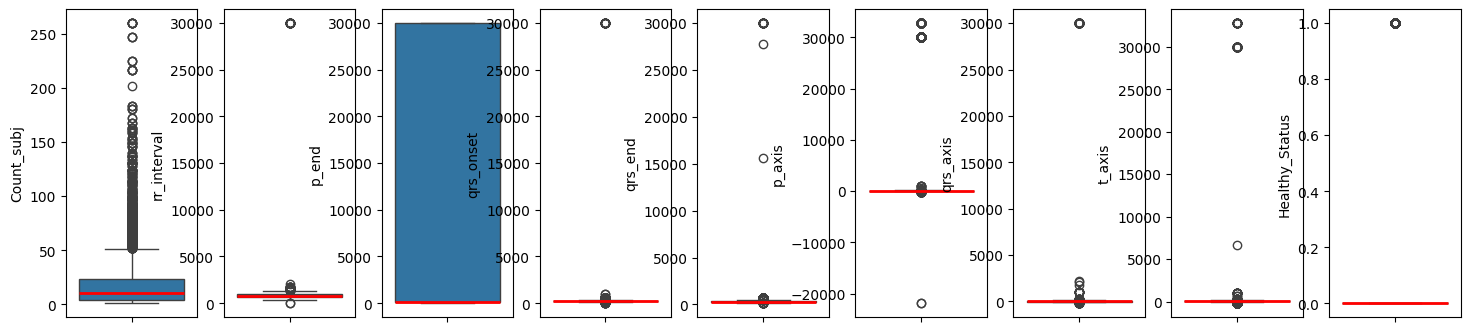

In [5]:
num_columns = [x for x in df.columns if df.dtypes[x] != 'object']
df_wo_reports = df[num_columns]
n = df_wo_reports.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = df_wo_reports.columns[i]
    sns.boxplot(y = df_wo_reports.iloc[:,i],data=df_wo_reports, medianprops={"color": "r", "linewidth": 2})

На части данных чётко видны выбросы, избавимся от них. Также, на всякий случай отсеем строки, в которых время начала волны или комплекса больше, чем конец (я, конечно, люблю фильм "Назад в будущее", но это не тот случай)

#### Удаление выбросов

In [6]:
# Фильтруем данные, удаляя строки с значениями больше 2000 в выбранных столбцах
filtered_df = df.loc[
    (df[num_columns] < 2000).all(axis=1)
]
# Добавляем дополнительный фильтр для проверки логичности данных в столбцах 'p_onset' и 'qrs_onset'
filtered_df = filtered_df.query(
    '(qrs_onset < qrs_end)'
)

filtered_df.shape[0]

7046

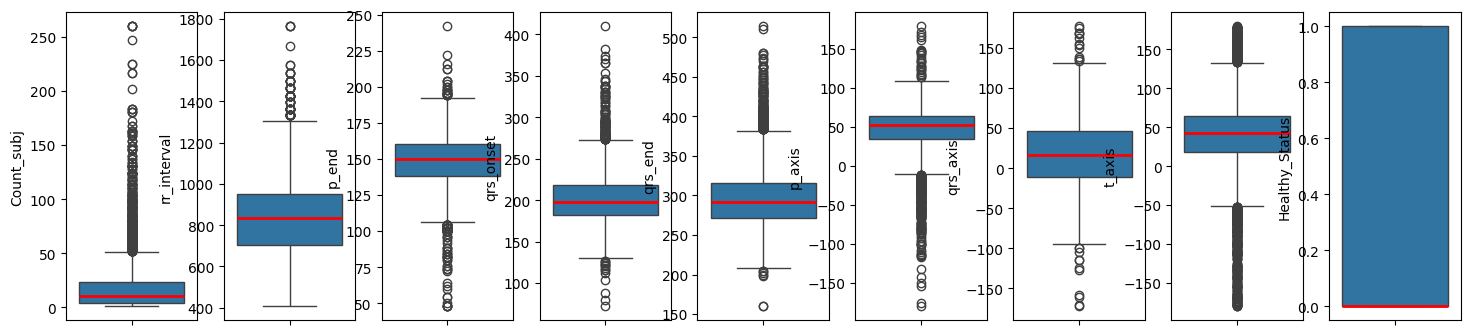

In [7]:
numb_cols = [x for x in filtered_df.columns if 'report' not in x and filtered_df.dtypes[x] != 'object']
n = filtered_df[numb_cols].shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = filtered_df[numb_cols].columns[i]
    sns.boxplot(
        y = filtered_df[numb_cols].iloc[:,i],
        data=filtered_df[numb_cols],
        medianprops={"color": "r", "linewidth": 2}
    )

#### Оценка взаимосвязи данных датасета

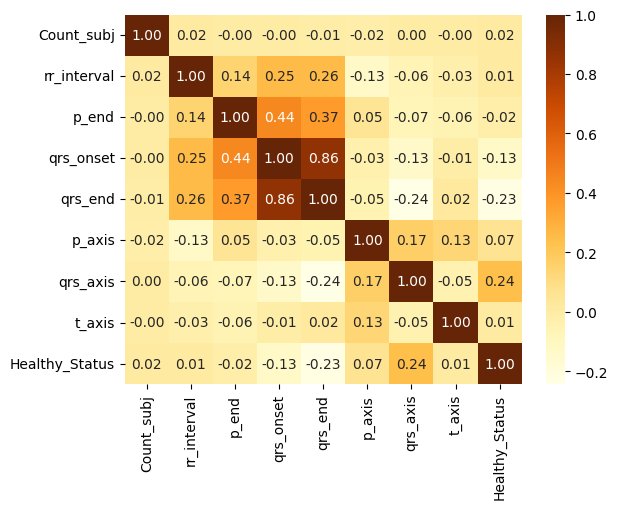

In [8]:
sns.heatmap(
    filtered_df.corr(),
    annot=True,
    fmt="0.2f",
    cmap='YlOrBr')
plt.show()

В таблице видна некоторая корреляция межу фичами времени, явных корреляций, близких к 1, не обнаружено. Построим корреляционную матрицу с помощью pairplot

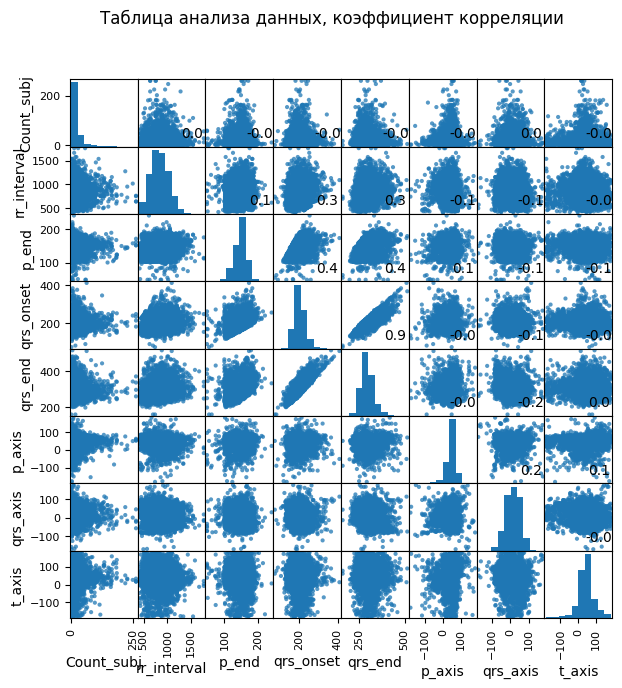

In [9]:
df = filtered_df.select_dtypes(include =[np.number]).copy() # keep only numerical columns
df.drop(columns=['Healthy_Status'], inplace=True)
# Remove rows and columns that would lead to df being singular
df = df.dropna(axis='columns')
df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
columnNames = list(df)
if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
    columnNames = columnNames[:10]
df = df[columnNames]
ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[7, 7], diagonal='hist')
corrs = df.corr().values
for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
    ax[i, j].annotate('%.1f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=10)
plt.suptitle('Таблица анализа данных, коэффициент корреляции')
plt.show()

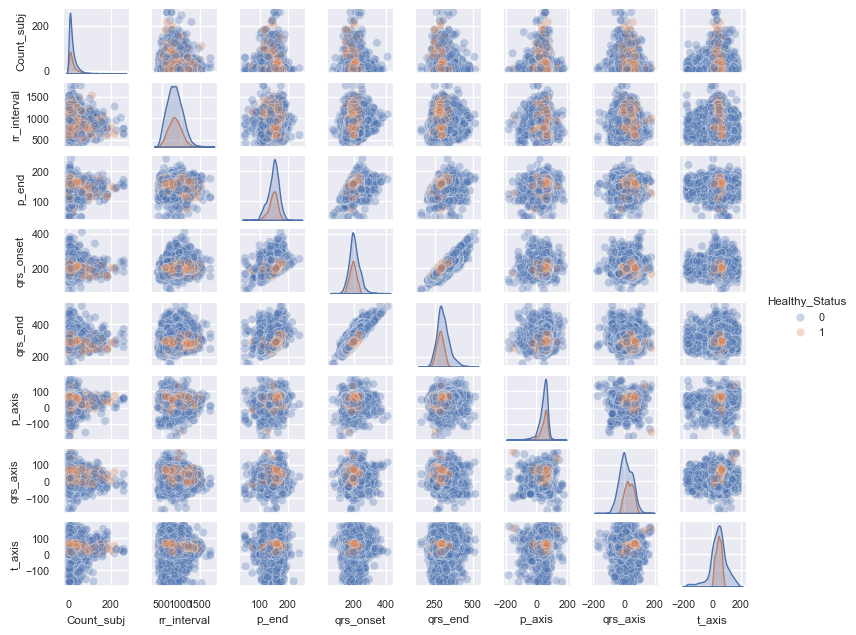

In [10]:
sns.set(font_scale=0.7)
sns.pairplot(
    filtered_df,
    hue = "Healthy_Status",
    height=0.8,
    aspect=1.2,
    plot_kws=dict(alpha=0.3)
)

Большая часть переменных имеет сильно перекрывающиеся распределения между классами, что говорит о том, что их будет сложно использовать по отдельности для хорошего разделения классов. Виден сильный дисбаланс классов

(7046, 9) (7046, 2)
[0.2920524  0.14982397]
0.4418763644168854
2 components at 44.19% explained variance
3 components at 57.35% explained variance
4 components at 69.85% explained variance
5 components at 81.01% explained variance
6 components at 90.09% explained variance


Text(0, 0.5, 'Second Principal Component')

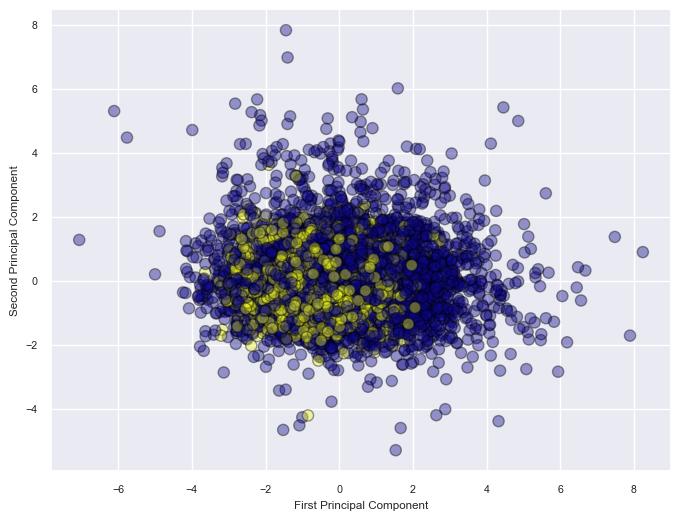

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


table_data_pca = filtered_df.select_dtypes(include =[np.number]).copy()
table_data_pca = table_data_pca.drop('Healthy_Status', axis = 1)

scaled_data = StandardScaler().fit(table_data_pca).transform(table_data_pca)
pca = PCA(n_components = 2).fit(scaled_data)
x_pca = pca.transform(scaled_data)
print(filtered_df.shape, x_pca.shape)

percent = pca.explained_variance_ratio_
print(percent)
print(sum(percent))

def pca_explained(X, threshold):
  features = X.shape[1]
  for i in range(2, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    # add all components explained variances
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if percent > threshold:
      break

pca_explained(scaled_data, 0.85)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=filtered_df['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Чёткого распределения кластеров без текстовой информвации не видно, без добавления фичей эмбединга сложно добиться хороших результатов. Из рисунка выше, следует, что разделение классов может быть тяжёлой задачей.

Text(0, 0.5, 'Second Principal Component')

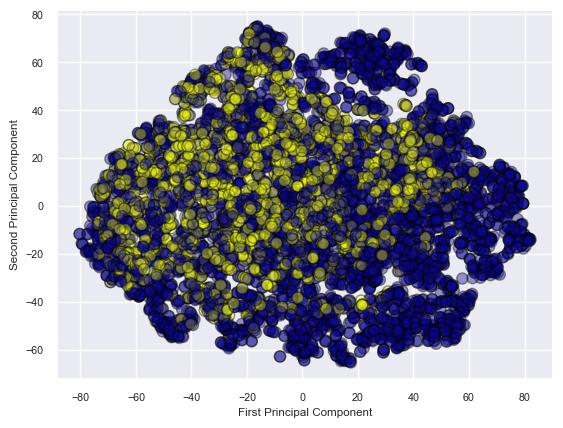

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state = 0)
scaled_data_tsne = tsne.fit_transform(scaled_data)
plt.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1], c=filtered_df['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')


Данный рисунок подкорепляет сделанные ранее выводы. Разделение произошло ничуть не лучше, чем при PCA, что говорит, что разделить классы будет тяжело

Time code evaluation for perplexity=1 in 25 sec
Time code evaluation for perplexity=5 in 24 sec
Time code evaluation for perplexity=10 in 25 sec
Time code evaluation for perplexity=15 in 26 sec
Time code evaluation for perplexity=20 in 28 sec
Time code evaluation for perplexity=30 in 31 sec
Time code evaluation for perplexity=40 in 34 sec
Time code evaluation for perplexity=50 in 39 sec
Time code evaluation for perplexity=100 in 49 sec


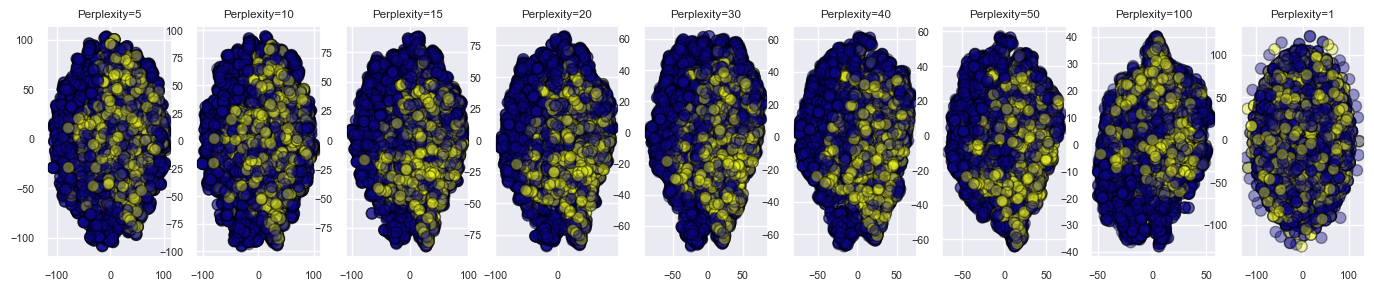

In [13]:
from sklearn import manifold
from time import time

n_components = 2
perplexities = [1, 5, 10, 15, 20, 30, 40, 50, 100]

(fig, subplots) = plt.subplots(1, len(perplexities), figsize=(17, 3))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i-1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
    )

    scaled_data_tsne = tsne.fit_transform(scaled_data)
    t1 = time()

    print("Time code evaluation for perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(
        scaled_data_tsne[:,0],
        scaled_data_tsne[:,1],
        c=filtered_df['Healthy_Status'],
        cmap='plasma',
        alpha=0.4,
        edgecolors='black',
        s=65
    )
    ax.axis("tight")

Что ж, получено ещё одно подтверждение сложности задачи разделения классов

#### Обогащение датасета, восстановление баланса классов

Из анализа выше ясно, что наибольший вклад дают эмбединги отчётов, поэтому можно безболезненно избывиться от всех других текстовых данных. Это также обеспечит более простую работу с autoML методами и методами обогащения датасета

In [14]:
filtered_df = filtered_df.select_dtypes(include =[np.number])
filtered_df.head(3)

,Count_subj,rr_interval,p_end,qrs_onset,qrs_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,27,659,128,170,258,81,77,79,0
1,93,722,124,162,246,77,75,70,0
2,3,600,130,162,244,79,72,77,1


Избавимся от дисбаланса классов при помощи метода SMOTE, упомянутого в ноутбуке с первой задачей(IRIS)

In [15]:
from imblearn.over_sampling import SMOTE

target_column = 'Healthy_Status'

smote = SMOTE(random_state=42)
X_expanded = filtered_df.drop(target_column, axis=1)
y_expanded = filtered_df[target_column]

X_resampled, y_resampled = smote.fit_resample(X_expanded, y_expanded)

resampled_df = pd.DataFrame(X_resampled, columns=X_expanded.columns)
resampled_df[target_column] = y_resampled

print(resampled_df[target_column].value_counts())
resampled_df.head(3)

0    5039
1    5039
Name: Healthy_Status, dtype: int64


,Count_subj,rr_interval,p_end,qrs_onset,qrs_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,27,659,128,170,258,81,77,79,0
1,93,722,124,162,246,77,75,70,0
2,3,600,130,162,244,79,72,77,1


Text(0, 0.5, 'Second Principal Component')

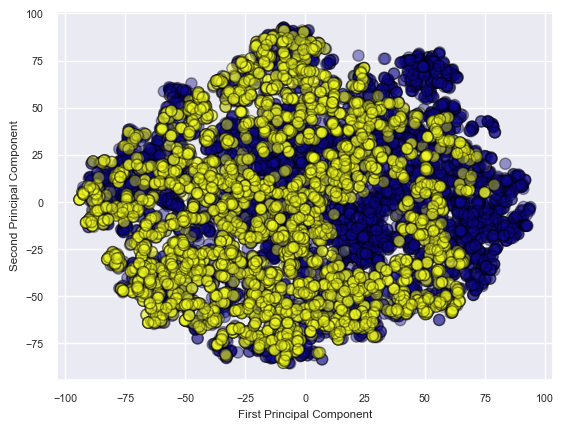

In [16]:
tsne_data = (
    resampled_df
    .select_dtypes(include =[np.number])
    .drop('Healthy_Status', axis = 1).copy()
)

scaled_data = StandardScaler().fit(tsne_data).transform(tsne_data)
tsne = TSNE(random_state = 0)
scaled_data_tsne = tsne.fit_transform(scaled_data)

plt.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1], c=resampled_df['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Как видно на рисунке выше, дисбаланс классов устранён, и классы всё также неразделимы. Сохраним получившиеся данные и приступим к обучению моделей

In [40]:
# resampled_df.to_parquet('processed_data.parquet', index=False)

resampled_df = pd.read_parquet('processed_data.parquet')
resampled_df.head(3)

,Count_subj,rr_interval,p_end,qrs_onset,qrs_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,27,659,128,170,258,81,77,79,0
1,93,722,124,162,246,77,75,70,0
2,3,600,130,162,244,79,72,77,1


# LAB3 AutoML

In [41]:
target_column = 'Healthy_Status'

X = resampled_df.drop(target_column, axis=1)
y = resampled_df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
import os

directory = 'autoML_models'
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f'directory "{directory}" was created')
else:
    print(f'directory "{directory}" already exists')

directory "autoML_models" already exists


### Lama

In [20]:
task = Task('multiclass')

automl = TabularAutoML(
    task=task,
    cpu_limit=-1,
    general_params={'use_algos': 'auto'},
    reader_params={'cv': 3, 'random_state': 42}
)

train_data = pd.concat([X_train, y_train], axis=1)
roles = {
    'target': target_column,
    'drop': []
}

oof_pred = automl.fit_predict(
    train_data=train_data,
    roles=roles,
    verbose=1
)

test_pred = automl.predict(X_test)
y_pred = test_pred.data.argmax(axis=1)

accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)

clear_output(wait=False)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 0.8501984126984127, Precision: 0.8538389808458616, Recall: 0.8501984126984127


In [21]:
with open(f'{directory}/lightautoml_electrocardiogram_m2_model.pkl', 'wb') as f:
    pickle.dump(automl, f)

with open(f'{directory}/lightautoml_electrocardiogram_m2_model.pkl', 'rb') as f:
    loaded_automl = pickle.load(f)

new_pred = loaded_automl.predict(X_test).data.argmax(axis=1)
accuracy, precision, recall = (
    accuracy_score(y_test, new_pred),
    precision_score(y_test, new_pred, average='weighted'),
    recall_score(y_test, new_pred, average='weighted'),
)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 0.8501984126984127, Precision: 0.8538389808458616, Recall: 0.8501984126984127


In [22]:
try:
    algo = loaded_automl.levels[0][0].ml_algos[0]
    print(f"Тип алгоритма: {type(algo).__name__}")
    
    if hasattr(algo, 'models'):
        model = algo.models[0]
        print(f"Тип модели: {type(model).__name__}")
        attrs_to_show = [attr for attr in dir(model) if not attr.startswith('_')]

        print(f"\n=== Параметры {type(model).__name__} ===")
        for attr in attrs_to_show:
            try:
                value = getattr(model, attr)
                
                if attr == 'model':
                    print("\nАрхитектура нейросети:")
                    print(value)
                elif attr == 'loss':
                    print(f"\nФункция потерь: {value.__class__.__name__}")
                else:
                    print(f"{attr}: {value}")
                    
            except Exception as e:
                print(f"{attr}: [не доступен]")

except Exception as e:
    print(f"Ошибка: {str(e)}")
    print("Используйте альтернативный метод:")
    print(loaded_automl.print_model_info())




Тип алгоритма: LinearLBFGS
Тип модели: TorchBasedLogisticRegression

=== Параметры TorchBasedLogisticRegression ===
categorical_idx: [0, 1]
cs: [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
data_size: 40
early_stopping: 2
embed_sizes: [11 11]
fit: <bound method TorchBasedLinearEstimator.fit of <lightautoml.ml_algo.torch_based.linear_model.TorchBasedLogisticRegression object at 0x0000017C8009A6D0>>

Функция потерь: TorchLossWrapper
max_iter: 100
metric: <lightautoml.tasks.losses.base.MetricFunc object at 0x0000017C8021FD60>

Архитектура нейросети:
CatMulticlass(
  (linear): Linear(in_features=38, out_features=2, bias=False)
  (final_act): SoftmaxClip(
    (smax): Softmax(dim=1)
  )
)
output_size: 2
predict: <bound method TorchBasedLogisticRegression.predict of <lightautoml.ml_algo.torch_based.linear_model.TorchBasedLogisticRegression object at 0x0000017C8009A6D0>>
tol: 1e-06


### Fedot

In [23]:
# Инициализация Fedot с явным указанием доступных моделей
automl_model = Fedot(
    problem='classification',
    preset='fast_train',
    # timeout=10,  # 2 минуты на подбор
    available_operations=['rf', 'logit','mlp', 'xgboost'],
    logging_level=logging.CRITICAL,
    with_tuning=True,
    n_jobs=-1,
    seed=42
)

try:
    pipeline = automl_model.fit(features=X_train, target=y_train)
    
    y_pred = automl_model.predict(features=X_test)
    
    accuracy, precision, recall = (
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='weighted'),
        recall_score(y_test, y_pred, average='weighted'),
    )
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

    
except Exception as e:
    print(f'Произошла ошибка: {str(e)}')
    print('Попробуйте обновить Fedot или использовать другой пресет')

2025-04-03 02:22:33,451 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'


Generations:   0%|          | 4/10000 [03:01<126:08:28, 45.43s/gen]


  0%|          | 14/100000 [01:50<218:56:22,  7.88s/trial, best loss: -0.9336490097026751]
Accuracy: 0.8675595238095238, Precision: 0.8774073682133329, Recall: 0.8675595238095238


In [24]:
def get_pipeline_info(pipeline):
    """Рекурсивно получает информацию о пайплайне"""
    info = []
    
    def process_node(node, level=0):
        node_info = {
            'type': str(node.operation.operation_type),
            'params': getattr(node, 'parameters', {}),
            'level': level,
            'node_object': node  # Сохраняем сам объект узла
        }
        info.append(node_info)
        
        if hasattr(node, 'nodes_from'):
            for parent in node.nodes_from:
                process_node(parent, level + 1)
    
    process_node(pipeline.root_node if hasattr(pipeline, 'root_node') else pipeline)
    return info

best_pipeline = automl_model.current_pipeline
pipeline_info = get_pipeline_info(best_pipeline)

for item in pipeline_info:
    print(f"{'  ' * item['level']}Узел: {item['type']}")
    print(f"{'  ' * item['level']}Параметры: {item['params']}")
    
    node = item['node_object']
    try:
        if hasattr(node, 'fitted_operation'):
            fitted_params = node.fitted_operation.get_params()
            print('Fitted_params: {')
            for param in fitted_params:
                print(f'\t{param}: {fitted_params[param]}')
            print('}')
    except Exception as e:
        print(f'Не удалось получить fitted параметры: {str(e)}')

Узел: rf
Параметры: {'n_jobs': 12, 'criterion': 'entropy', 'max_features': 0.34845021389429737, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False}
Fitted_params: {
	bootstrap: False
	ccp_alpha: 0.0
	class_weight: None
	criterion: entropy
	max_depth: None
	max_features: 0.34845021389429737
	max_leaf_nodes: None
	max_samples: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 4
	min_weight_fraction_leaf: 0.0
	n_estimators: 100
	n_jobs: 1
	oob_score: False
	random_state: None
	verbose: 0
	warm_start: False
}


In [25]:
with open(f'{directory}/fedot_model.pkl', 'wb') as f:
    pickle.dump(automl_model, f)

with open(f'{directory}/fedot_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

y_pred = loaded_model.predict(features=X_test)

accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 0.8675595238095238, Precision: 0.8774073682133329, Recall: 0.8675595238095238


### TPOT

In [26]:
tpot = TPOTClassifier(generations=4, population_size=10, random_state=42, verbosity=2, n_jobs=-1, max_time_mins=30, cv=3)
tpot.fit(X_train, y_train)

Version 0.12.1 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


                                                                            
Generation 1 - Current best internal CV score: 0.8354004861000348
                                                                            
Generation 2 - Current best internal CV score: 0.8358968409035863
                                                                            
Generation 3 - Current best internal CV score: 0.8358968409035863
                                                                            
Generation 4 - Current best internal CV score: 0.8358968409035863
                                                                            
Best pipeline: RandomForestClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=8, min_samples_split=4, n_estimators=100)


TPOTClassifier(cv=3, generations=4, max_time_mins=30, n_jobs=-1,
               population_size=10, random_state=42, verbosity=2)

In [27]:
y_pred = tpot.predict(X_test)
accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 0.8467261904761905, Precision: 0.858671061344892, Recall: 0.8467261904761905


In [28]:
from joblib import dump

final_pipeline = tpot.fitted_pipeline_

dump(final_pipeline, f'{directory}/tpot_final_pipeline.joblib')

from joblib import load
from sklearn.metrics import accuracy_score

loaded_pipeline = load(f'{directory}/tpot_final_pipeline.joblib')

y_pred = loaded_pipeline.predict(X_test)
accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 0.8467261904761905, Precision: 0.858671061344892, Recall: 0.8467261904761905


In [29]:
for step_name, step_estimator in loaded_pipeline.steps:
    print(f"Тип: {type(step_estimator).__name__}")
    params = step_estimator.get_params()
    print("Параметры:")
    for el in params:
        print(f'\t{el}: {params[el]}')

Тип: PolynomialFeatures
Параметры:
	degree: 2
	include_bias: False
	interaction_only: False
	order: C
Тип: RandomForestClassifier
Параметры:
	bootstrap: True
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: None
	max_features: 0.2
	max_leaf_nodes: None
	max_samples: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 8
	min_samples_split: 4
	min_weight_fraction_leaf: 0.0
	n_estimators: 100
	n_jobs: None
	oob_score: False
	random_state: 42
	verbose: 0
	warm_start: False


Как видно по метрикам, все модели +- справились с поставленной задачей. Лучше всех в этот раз справился Fedot

# Lab4 MLFlow

Для дальнейшей работы возьмём TPOT, его интерпретация показалась наиболее удобной. Для нахождения оптимальных параметров значительно увеличим количество ремурсов на ресёрч

In [44]:
tpot = TPOTClassifier(generations=20, population_size=50, random_state=42, verbosity=2, n_jobs=-1, max_time_mins=90, cv=3)
tpot.fit(X_train, y_train)
print(tpot.fitted_pipeline_)

y_pred = tpot.predict(X_test)
accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Version 0.12.1 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


                                                                             
Generation 1 - Current best internal CV score: 0.8444558345295691
                                                                              
Generation 2 - Current best internal CV score: 0.8444558345295691
                                                                              
Generation 3 - Current best internal CV score: 0.8444558345295691
                                                                              
Generation 4 - Current best internal CV score: 0.8444558345295691
                                                                              
Generation 5 - Current best internal CV score: 0.8456960061967971
                                                                              
Generation 6 - Current best internal CV score: 0.8461920840939031
                                                                              
Generation 7 - Current best internal CV score: 0.846

Реализуем руками полученный пайплайн

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, FunctionTransformer
from sklearn.decomposition import FastICA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from copy import copy  # Import copy

# TPOT pipeline
pipeline = Pipeline([
    ('featureunion', FeatureUnion(transformer_list=[
        ('pipeline', Pipeline([
            ('normalizer', Normalizer(norm='l1')),
            ('fastica', FastICA(random_state=42, tol=0.30000000000000004))
        ])),
        ('functiontransformer', FunctionTransformer(func=copy))  # Use copy function
    ])),
    ('randomforestclassifier', RandomForestClassifier(
        bootstrap=False, criterion='gini', max_features=0.25,
        min_samples_leaf=1, min_samples_split=7, n_estimators=100, random_state=42
    ))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')



Accuracy: 0.8740079365079365
Precision: 0.8797314720702988
Recall: 0.8740079365079365


Дальнейшие эксперименты с параметрами показали,
что самый большой эффект даёт работа с параметрами `RandomForestClassifier`,
а остальные параметры либо не дают эффекта, либо мешают.
**Поэтому займёмся настройкой конкретно `RandomForestClassifier`**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('randomforestclassifier', RandomForestClassifier(
        bootstrap=False, criterion='gini', random_state=42
    ))
])

param_grid = {
    'randomforestclassifier__n_estimators': [80, 100, 120, 140],
    'randomforestclassifier__max_features': [0.2, 0.25, 0.3, 0.35],
    'randomforestclassifier__min_samples_split': [2, 4, 6, 8],
    'randomforestclassifier__min_samples_leaf': [1, 2, 3, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


Fitting 3 folds for each of 256 candidates, totalling 768 fits
Best parameters: {'randomforestclassifier__max_features': 0.25, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__n_estimators': 120}
Best score: 0.8589919875827258
Accuracy: 0.8745039682539683
Precision: 0.8826424647707535
Recall: 0.8745039682539683


Отлично, нам удалось улучшить показатели метрик! Делаем итоговую модель!

In [ ]:
final_model = RandomForestClassifier(
    bootstrap=False,  # Параметр из TPOT
    criterion='gini', # Параметр из TPOT
    max_features=0.25, # Оптимизированный параметр
    min_samples_leaf=1, # Оптимизированный параметр
    min_samples_split=6, # Оптимизированный параметр
    n_estimators=120, # Оптимизированный параметр
    random_state=42 # Для воспроизводимости
)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


dump(final_model, f'{directory}/final_tpot_model.joblib')


Accuracy: 0.8745039682539683
Precision: 0.8826424647707535
Recall: 0.8745039682539683


['autoML_models/final_tpot_model.joblib']

Таким образом нам удалось существенно нарастить метрики:
- `Accuracy`
    - 0.8467261904761905 --> 0.8745039682539683
- `Precision`
    - 0.858671061344892 --> 0.8826424647707535
- `Recall`
    - 0.8467261904761905 --> 0.8745039682539683

Перейдём к визуализации

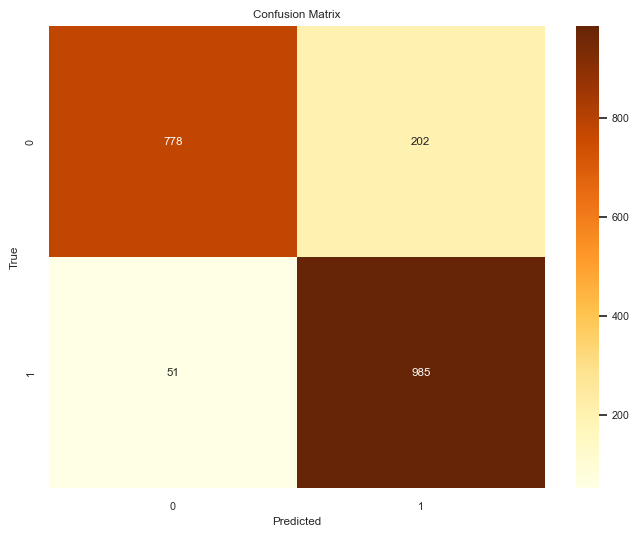

In [62]:
loaded_model = load(f'{directory}/final_tpot_model.joblib')

y_pred = loaded_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', 
            xticklabels=resampled_df[target_column].unique(),
            yticklabels=resampled_df[target_column].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Как видно, модель действительно делает довольно точные прогнозы

### Развертывание модели в MLFlow

1. Вводим в командную строку: `mlflow server --host 127.0.0.1 --port 8080`
2. Переходим по адресу: `http://127.0.0.1:8080`

Продемонстрируем работу с MLFlow на примере Lama

In [40]:
def collect_model_info(loaded_automl):
    model_info = {
        'algorithm_type': None,
        'model_type': None,
        'parameters': {},
        'architecture': None,
        'loss_function': None,
        'error': None,
        'alternative_info': None
    }
    
    try:
        algo = loaded_automl.levels[0][0].ml_algos[0]
        model_info['algorithm_type'] = type(algo).__name__
        
        if hasattr(algo, 'models'):
            model = algo.models[0]
            model_info['model_type'] = type(model).__name__
            attrs_to_show = [attr for attr in dir(model) if not attr.startswith('_')]

            for attr in attrs_to_show:
                try:
                    value = getattr(model, attr)
                    
                    if attr == 'model':
                        model_info['architecture'] = str(value)
                    elif attr == 'loss':
                        model_info['loss_function'] = value.__class__.__name__
                    else:
                        model_info['parameters'][attr] = str(value)
                        
                except Exception as e:
                    model_info['parameters'][attr] = '[не доступен]'

    except Exception as e:
        model_info['error'] = str(e)
        model_info['alternative_info'] = str(loaded_automl.print_model_info())
    
    return model_info

In [64]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("RandomForest_ECG_Classification")

params = {
    'bootstrap': False,
    'criterion': 'gini',
    'max_features': 0.25,
    'min_samples_leaf': 1,
    'min_samples_split': 6,
    'n_estimators': 120,
    'random_state': 42
}

with mlflow.start_run():
    mlflow.log_params(params)

    final_model = RandomForestClassifier(**params)

    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    mlflow.log_metrics({
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    })

    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    mlflow.sklearn.log_model(final_model, "randomforest_model")

    model_path = f"{directory}/randomforest_model.joblib"
    dump(final_model, model_path)
    mlflow.log_artifact(model_path)

print("Finished training and logging model to MLflow.")

Accuracy: 0.8745, Precision: 0.8826, Recall: 0.8745


2025/04/04 03:55:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/04 03:55:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run useful-sow-524 at: http://127.0.0.1:8080/#/experiments/894102329784941331/runs/66886c085c334f8d9d0314a5f9c9e9e2.
2025/04/04 03:55:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/894102329784941331.


Finished training and logging model to MLflow.
